In [1]:
import pandas as pd


ssp = 585 #126, 370, 585

# Dateien einlesen
df1 = pd.read_csv('output/total/combined_temperature_data_cleaned_with_types_1981_2010.csv')
df2 = pd.read_csv(f'output/total/combined_temperature_data_{ssp}_cleaned_with_types_2011_2040.csv')
df3 = pd.read_csv(f'output/total/combined_temperature_data_{ssp}_cleaned_with_types_2041_2070.csv')
df4 = pd.read_csv(f'output/total/combined_temperature_data_{ssp}_cleaned_with_types_2071_2100.csv')

# Datenrahmen basierend auf Koordinaten, Monat und Temperaturtyp zusammenführen (innerer Join auf x-Koord, y-Koord, Monat und Temp_Type)
merged_df = pd.merge(df1, df2, on=['x-Koord', 'y-Koord', 'Monat', 'Temp_Type'], suffixes=('_1981_2010', '_2011_2040'))
print("Nach dem ersten Merge:", merged_df.columns)

merged_df = pd.merge(merged_df, df3, on=['x-Koord', 'y-Koord', 'Monat', 'Temp_Type'], suffixes=('_2011_2040', '_2041_2070'))
print("Nach dem zweiten Merge:", merged_df.columns)

merged_df = pd.merge(merged_df, df4, on=['x-Koord', 'y-Koord', 'Monat', 'Temp_Type'], suffixes=('_2041_2070', '_2071_2100'))
print("Nach dem dritten Merge:", merged_df.columns)

# Nur relevante Spalten behalten (Stadt aus beiden Dateien, x-Koord, y-Koord, Monat, Temp_Type, Temp aus allen Dateien)
result_df = merged_df[['City_1981_2010', 'Country_1981_2010', 'x-Koord', 'y-Koord', 'Monat', 'Temp_Type', 
                       'Temp_1981_2010', 'Temp_2011_2040', 'Temp_2041_2070', 'Temp_2071_2100']]

# Spalten umbenennen
result_df = result_df.rename(columns={'City_1981_2010': 'City', 'Country_1981_2010': 'Country', 'Monat': 'Month'})

# Ergebnis in eine neue CSV-Datei exportieren
result_df.to_csv('output/merged_output.csv', index=False)

# Optional: Ausgabe der ersten Zeilen des Ergebnisses
print(result_df.head())


Nach dem ersten Merge: Index(['City_1981_2010', 'Country_1981_2010', 'x-Koord', 'y-Koord',
       'Temp_1981_2010', 'Temp_Type', 'Monat', 'City_2011_2040',
       'Country_2011_2040', 'Temp_2011_2040'],
      dtype='object')
Nach dem zweiten Merge: Index(['City_1981_2010', 'Country_1981_2010', 'x-Koord', 'y-Koord',
       'Temp_1981_2010', 'Temp_Type', 'Monat', 'City_2011_2040',
       'Country_2011_2040', 'Temp_2011_2040', 'City', 'Country', 'Temp'],
      dtype='object')
Nach dem dritten Merge: Index(['City_1981_2010', 'Country_1981_2010', 'x-Koord', 'y-Koord',
       'Temp_1981_2010', 'Temp_Type', 'Monat', 'City_2011_2040',
       'Country_2011_2040', 'Temp_2011_2040', 'City_2041_2070',
       'Country_2041_2070', 'Temp_2041_2070', 'City_2071_2100',
       'Country_2071_2100', 'Temp_2071_2100'],
      dtype='object')
       City Country    x-Koord    y-Koord  Month Temp_Type  Temp_1981_2010  \
0  Winnipeg  Canada -97.187639  49.979027      1       tas          -16.35   
1  Winnipeg 

In [2]:
import pycountry_convert as pc

def custom_country_to_continent(country_name):
    # Manuelle Zuweisungen basierend auf spezifischen Schlüsselwörtern
    keyword_continent_map = {
        'Venezuela': 'South America',
        'Korea': 'Asia',
        'Iran': 'Asia',
        'Bolivia': 'South America',
        'Ivoire':'Africa',
        'Macedonia':'Europe',
        'Palestine':'Asia',
        'Hong Kong':'Asia'
        # Weitere manuelle Zuordnungen hier hinzufügen
    }
    
    # Überprüfe, ob eines der Schlüsselwörter im Ländernamen vorkommt
    for keyword, continent in keyword_continent_map.items():
        if keyword in country_name:
            return continent
    
    # Fallback zu pycountry_convert, wenn kein Schlüsselwort gefunden wird
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continents = {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania',
            'AN': 'Antarctica'
        }
        return continents.get(continent_code, 'Unknown')
    except Exception as e:
        print(f"Error processing {country_name}: {e}")
        return 'Unknown'

# Beispielanwendung auf den Datensatz
result_df['Continent'] = result_df['Country'].apply(custom_country_to_continent)

# Überprüfen, ob die Kontinente korrekt zugeordnet wurden
#print(result_df[['Country', 'Continent']].head())


In [3]:
import geopandas as gpd
import pandas as pd

# Shapedatei einlesen
shape_gdf = gpd.read_file('input/Morphological_Urban_Area_all_SSP.shp')

# Optional: Zeige die ersten Zeilen, um die Struktur des GeoDataFrames zu sehen


# Nur die relevanten Spalten auswählen, die für den Merge benötigt werden
# Define the SSP scenario to use: Choose between 'SSP1', 'SSP3', or 'SSP5'
selected_ssp = 'SSP5'  # Change this to 'SSP3' or 'SSP5' as needed

# Create a list of columns based on the selected SSP
columns_to_select = ['Aggname', 
                     f'{selected_ssp}_2020s', 
                     f'{selected_ssp}_2025s', 
                     f'{selected_ssp}_2040s', 
                     f'{selected_ssp}_2070s', 
                     f'{selected_ssp}_2100s']
# Select only the relevant columns for the merge
shape_df_selected = shape_gdf[columns_to_select]

# Zusammenführung der Daten basierend auf der 'City'-Spalte in result_df und 'Aggname' in shape_df_selected
merged_with_shape = pd.merge(result_df, shape_df_selected, left_on='City', right_on='Aggname', how='inner')

# Entferne die Spalte 'Aggname' aus dem gemergten DataFrame
merged_with_shape = merged_with_shape.drop(columns=['Aggname'])

# Optional: Ausgabe der Spalten nach dem Entfernen von 'Aggname'
print("Nach dem Entfernen der Spalte 'Aggname':", merged_with_shape.columns)

# Optional: Exportiere das Ergebnis in eine CSV-Datei, wenn du es brauchst
merged_with_shape.to_csv('output/merged_with_selected_shape_output.csv', index=False)

# Ausgabe der ersten Zeilen des Ergebnisses
print(merged_with_shape.head())


Nach dem Entfernen der Spalte 'Aggname': Index(['City', 'Country', 'x-Koord', 'y-Koord', 'Month', 'Temp_Type',
       'Temp_1981_2010', 'Temp_2011_2040', 'Temp_2041_2070', 'Temp_2071_2100',
       'Continent', 'SSP5_2020s', 'SSP5_2025s', 'SSP5_2040s', 'SSP5_2070s',
       'SSP5_2100s'],
      dtype='object')
       City Country    x-Koord    y-Koord  Month Temp_Type  Temp_1981_2010  \
0  Winnipeg  Canada -97.187639  49.979027      1       tas          -16.35   
1  Winnipeg  Canada -97.187639  49.979027      1       tas          -16.35   
2  Winnipeg  Canada -97.187639  49.979027      1       tas          -16.35   
3  Winnipeg  Canada -97.187639  49.979027      1       tas          -16.35   
4  Winnipeg  Canada -97.187639  49.979027      1       tas          -16.35   

   Temp_2011_2040  Temp_2041_2070  Temp_2071_2100      Continent  \
0          -15.65          -12.75          -10.15  North America   
1          -15.65          -12.75          -10.15  North America   
2          -15.65

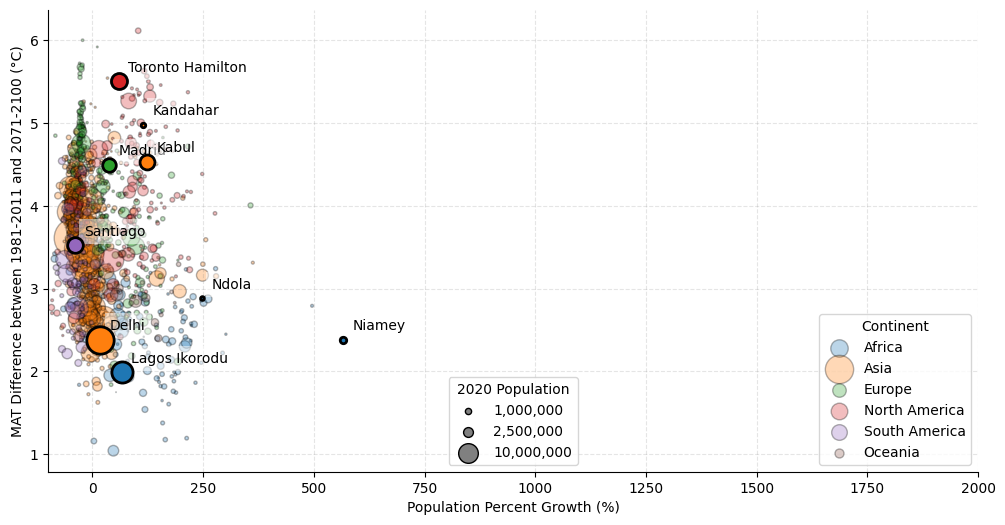

Biggest cities (pop > 3 million) with highest temperature increase:
                                                City      Continent  \
0                                 Al-Qahirah (Cairo)         Africa   
1                                      Lagos Ikorodu         Africa   
2          TehranTehran Karaj Eslamshahr Malard Qods           Asia   
3  Seoul Incheon Suweon Seongnam Goyang Bucheon A...           Asia   
4  Suzhou, Jiangsu Wuxi, Jiangsu Changzhou, Jiang...           Asia   
5                                      Beijing Sanhe           Asia   
6               Hangzhou Shaoxing Cixi Yuyao Shangyu           Asia   
7  Los Angeles-Long Beach-Santa Ana Riverside-San...  North America   
8                                       Buenos Aires  South America   

     SSP5_2020s  Population_Percent_Growth  Temp_Diff_2071_2100  
0  1.581140e+07                 -14.131576             3.545237  
1  1.160579e+07                  66.177108             1.984502  
2  1.220963e+07        

/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_28632/2766962281.py:115: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_temp_increase = big_cities.groupby('Continent', group_keys=False).apply(
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_28632/2766962281.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_pop_growth = merged_data.groupby('Continent', group_keys=False).apply

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming merged_with_shape is your DataFrame with 32 columns
# --- Set the SSP scenario here ---
SCENARIO = 'SSP5'  # Change to 'SSP3' or 'SSP1' as needed
pop_2020s = f'{SCENARIO}_2020s'
pop_2100s = f'{SCENARIO}_2100s'


# 1. Filter for rows with Temp_Type 'tas'
merged_with_shape_tas = merged_with_shape[merged_with_shape['Temp_Type'] == 'tas']

# 2. Calculate the mean annual temperature per city for the two periods
mean_temps_1981_2010 = merged_with_shape_tas.groupby('City')['Temp_1981_2010'].mean().reset_index()
mean_temps_2071_2100 = merged_with_shape_tas.groupby('City')['Temp_2071_2100'].mean().reset_index()

# Rename columns for clarity
mean_temps_1981_2010.columns = ['City', 'Mean_1981_2010']
mean_temps_2071_2100.columns = ['City', 'Mean_2071_2100']

# Merge the two DataFrames on 'City'
mean_temps = pd.merge(mean_temps_1981_2010, mean_temps_2071_2100, on='City')

# Calculate the temperature difference (2071-2100 minus 1981-2010)
mean_temps['Temp_Diff_2071_2100'] = mean_temps['Mean_2071_2100'] - mean_temps['Mean_1981_2010']

# 3. Extract additional unique city information (Continent, SSP3_2020s, SSP3_2100s)
city_info = merged_with_shape_tas.groupby('City').first().reset_index()[['City', 'Continent', pop_2020s, pop_2100s]]

# Merge the temperature data with the city info
merged_data = pd.merge(mean_temps, city_info, on='City')

# 4. Calculate the population percent growth from the 2020s to the 2100s
merged_data['Population_Percent_Growth'] = ((merged_data[pop_2100s] - merged_data[pop_2020s]) / 
                                             merged_data[pop_2020s]) * 100

# 5. Define a color palette for the continents
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b'
}

# Create the scatterplot
plt.figure(figsize=(12,6))#8,4 #12,6
ax = plt.gca()
for continent, color in continent_palette.items():
    subset = merged_data[merged_data['Continent'] == continent]
    plt.scatter(subset['Population_Percent_Growth'],
                subset['Temp_Diff_2071_2100'],
                s=subset[pop_2020s] / 50000,  # Adjust scaling factor as needed
                alpha=0.3,
                edgecolor=(0, 0, 0, 0.3),
                label=continent,
                color=color)

# Remove the top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a transparent grid in the background
plt.grid(True, color='gray', linestyle='--', alpha=0.2)

# Position the continent legend to the right side of the figure.
# "center left" positions the legend to the left of the bbox anchor.
continent_legend = plt.legend(title='Continent', loc='lower right')#, bbox_to_anchor=(1, 0.75)
ax.add_artist(continent_legend)  # Add the continent legend to the axes

# Create dummy scatter plots for marker size legend.
pop_values = [1000000, 2500000, 10000000]  # Representative population values
handles = []
for pop in pop_values:
    size = pop / 50000  # Same scaling factor as in the scatter plot
    handles.append(plt.scatter([], [], s=size, edgecolor='black', color='gray', label=f'{pop:,.0f}'))

# Position the population legend also on the right side.
plt.legend(handles=handles, title='2020 Population', loc='lower center') #, bbox_to_anchor=(1, 0.15)

# --- Highlight Specific Cities ---
highlight_cities = ["Lagos Ikorodu", "Santiago", "Madrid", "Kandahar", "Delhi", 
                    "Toronto Hamilton", "Ndola", "Kabul", "Niamey"]

for city in highlight_cities:
    city_data = merged_data[merged_data["City"] == city]
    if not city_data.empty:
        # Extract coordinates and 2020 population
        x_val = city_data["Population_Percent_Growth"].values[0]
        y_val = city_data["Temp_Diff_2071_2100"].values[0]
        pop_val = city_data[pop_2020s].values[0]
        # Get the city's continent to reuse its color
        continent = city_data["Continent"].values[0]
        highlight_color = mcolors.to_rgba(continent_palette[continent], alpha=1)
        plt.scatter(x_val, y_val, s=pop_val / 50000, facecolors=highlight_color,
                    edgecolors='black', linewidth=2, zorder=10)
        plt.annotate(city, (x_val, y_val), textcoords="offset points",
                     xytext=(7, 7), ha="left", fontsize=10, color='black',
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# Set xscale, title, and axis labels
#plt.xscale('log')
plt.xlabel('Population Percent Growth (%)', fontsize=10)
plt.ylabel('MAT Difference between 1981-2011 and 2071-2100 (°C)', fontsize=10)
plt.xlim((-100,2000))
# Adjust layout to leave space on the right for legends.
#plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()

# --- Biggest Cities with High Temperature Increase ---
big_cities = merged_data[merged_data[pop_2020s] > 10000000]
top_temp_increase = big_cities.groupby('Continent', group_keys=False).apply(
    lambda df: df.nlargest(5, 'Temp_Diff_2071_2100')
).reset_index(drop=True)
print("Biggest cities (pop > 3 million) with highest temperature increase:")
print(top_temp_increase[['City', 'Continent', pop_2020s, 'Population_Percent_Growth', 'Temp_Diff_2071_2100']])

# --- Fastest Growing Cities ---
top_pop_growth = merged_data.groupby('Continent', group_keys=False).apply(
    lambda df: df.nlargest(5, 'Population_Percent_Growth')
).reset_index(drop=True)
print("\nFastest growing cities (by population percent growth):")
print(top_pop_growth[['City', 'Continent', 'Population_Percent_Growth', pop_2020s]])


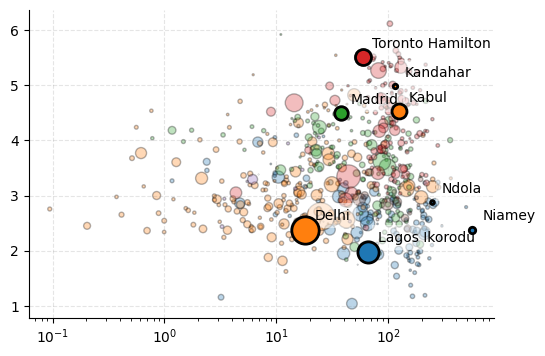

Biggest cities (pop > 3 million) with highest temperature increase:
                                                City      Continent  \
0                                 Al-Qahirah (Cairo)         Africa   
1                                      Lagos Ikorodu         Africa   
2          TehranTehran Karaj Eslamshahr Malard Qods           Asia   
3  Seoul Incheon Suweon Seongnam Goyang Bucheon A...           Asia   
4  Suzhou, Jiangsu Wuxi, Jiangsu Changzhou, Jiang...           Asia   
5                                      Beijing Sanhe           Asia   
6               Hangzhou Shaoxing Cixi Yuyao Shangyu           Asia   
7  Los Angeles-Long Beach-Santa Ana Riverside-San...  North America   
8                                       Buenos Aires  South America   

     SSP5_2020s  Population_Percent_Growth  Temp_Diff_2071_2100  
0  1.581140e+07                 -14.131576             3.545237  
1  1.160579e+07                  66.177108             1.984502  
2  1.220963e+07        

/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_28632/3834589066.py:115: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_temp_increase = big_cities.groupby('Continent', group_keys=False).apply(
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_28632/3834589066.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_pop_growth = merged_data.groupby('Continent', group_keys=False).apply

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming merged_with_shape is your DataFrame with 32 columns
# --- Set the SSP scenario here ---
SCENARIO = 'SSP5'  # Change to 'SSP3' or 'SSP1' as needed
pop_2020s = f'{SCENARIO}_2020s'
pop_2100s = f'{SCENARIO}_2100s'


# 1. Filter for rows with Temp_Type 'tas'
merged_with_shape_tas = merged_with_shape[merged_with_shape['Temp_Type'] == 'tas']

# 2. Calculate the mean annual temperature per city for the two periods
mean_temps_1981_2010 = merged_with_shape_tas.groupby('City')['Temp_1981_2010'].mean().reset_index()
mean_temps_2071_2100 = merged_with_shape_tas.groupby('City')['Temp_2071_2100'].mean().reset_index()

# Rename columns for clarity
mean_temps_1981_2010.columns = ['City', 'Mean_1981_2010']
mean_temps_2071_2100.columns = ['City', 'Mean_2071_2100']

# Merge the two DataFrames on 'City'
mean_temps = pd.merge(mean_temps_1981_2010, mean_temps_2071_2100, on='City')

# Calculate the temperature difference (2071-2100 minus 1981-2010)
mean_temps['Temp_Diff_2071_2100'] = mean_temps['Mean_2071_2100'] - mean_temps['Mean_1981_2010']

# 3. Extract additional unique city information (Continent, SSP3_2020s, SSP3_2100s)
city_info = merged_with_shape_tas.groupby('City').first().reset_index()[['City', 'Continent', pop_2020s, pop_2100s]]

# Merge the temperature data with the city info
merged_data = pd.merge(mean_temps, city_info, on='City')

# 4. Calculate the population percent growth from the 2020s to the 2100s
merged_data['Population_Percent_Growth'] = ((merged_data[pop_2100s] - merged_data[pop_2020s]) / 
                                             merged_data[pop_2020s]) * 100

# 5. Define a color palette for the continents
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b'
}

# Create the scatterplot
plt.figure(figsize=(6,4))#8,4 #12,6
ax = plt.gca()
for continent, color in continent_palette.items():
    subset = merged_data[merged_data['Continent'] == continent]
    plt.scatter(subset['Population_Percent_Growth'],
                subset['Temp_Diff_2071_2100'],
                s=subset[pop_2020s] / 50000,  # Adjust scaling factor as needed
                alpha=0.3,
                edgecolor=(0, 0, 0, 0.3),
                label=continent,
                color=color)

# Remove the top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a transparent grid in the background
plt.grid(True, color='gray', linestyle='--', alpha=0.2)

# Position the continent legend to the right side of the figure.
# "center left" positions the legend to the left of the bbox anchor.
#continent_legend = plt.legend(title='Continent', loc='lower right')#, bbox_to_anchor=(1, 0.75)
#ax.add_artist(continent_legend)  # Add the continent legend to the axes

# Create dummy scatter plots for marker size legend.
pop_values = [1000000, 2500000, 10000000]  # Representative population values
handles = []
for pop in pop_values:
    size = pop / 50000  # Same scaling factor as in the scatter plot
    handles.append(plt.scatter([], [], s=size, edgecolor='black', color='gray', label=f'{pop:,.0f}'))

# Position the population legend also on the right side.
#plt.legend(handles=handles, title='2020 Population', loc='lower center') #, bbox_to_anchor=(1, 0.15)

# --- Highlight Specific Cities ---
highlight_cities = ["Lagos Ikorodu", "Santiago", "Madrid", "Kandahar", "Delhi", 
                    "Toronto Hamilton", "Ndola", "Kabul", "Niamey"]

for city in highlight_cities:
    city_data = merged_data[merged_data["City"] == city]
    if not city_data.empty:
        # Extract coordinates and 2020 population
        x_val = city_data["Population_Percent_Growth"].values[0]
        y_val = city_data["Temp_Diff_2071_2100"].values[0]
        pop_val = city_data[pop_2020s].values[0]
        # Get the city's continent to reuse its color
        continent = city_data["Continent"].values[0]
        highlight_color = mcolors.to_rgba(continent_palette[continent], alpha=1)
        plt.scatter(x_val, y_val, s=pop_val / 50000, facecolors=highlight_color,
                    edgecolors='black', linewidth=2, zorder=10)
        plt.annotate(city, (x_val, y_val), textcoords="offset points",
                     xytext=(7, 7), ha="left", fontsize=10, color='black',
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# Set xscale, title, and axis labels
plt.xscale('log')
#plt.xlabel('Population Percent Growth (%)', fontsize=10)
#plt.ylabel('MAT Difference between 1981-2011 and 2071-2100 (°C)', fontsize=10)
#plt.xlim((-100,1000))
# Adjust layout to leave space on the right for legends.
#plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()

# --- Biggest Cities with High Temperature Increase ---
big_cities = merged_data[merged_data[pop_2020s] > 10000000]
top_temp_increase = big_cities.groupby('Continent', group_keys=False).apply(
    lambda df: df.nlargest(5, 'Temp_Diff_2071_2100')
).reset_index(drop=True)
print("Biggest cities (pop > 3 million) with highest temperature increase:")
print(top_temp_increase[['City', 'Continent', pop_2020s, 'Population_Percent_Growth', 'Temp_Diff_2071_2100']])

# --- Fastest Growing Cities ---
top_pop_growth = merged_data.groupby('Continent', group_keys=False).apply(
    lambda df: df.nlargest(5, 'Population_Percent_Growth')
).reset_index(drop=True)
print("\nFastest growing cities (by population percent growth):")
print(top_pop_growth[['City', 'Continent', 'Population_Percent_Growth', pop_2020s]])


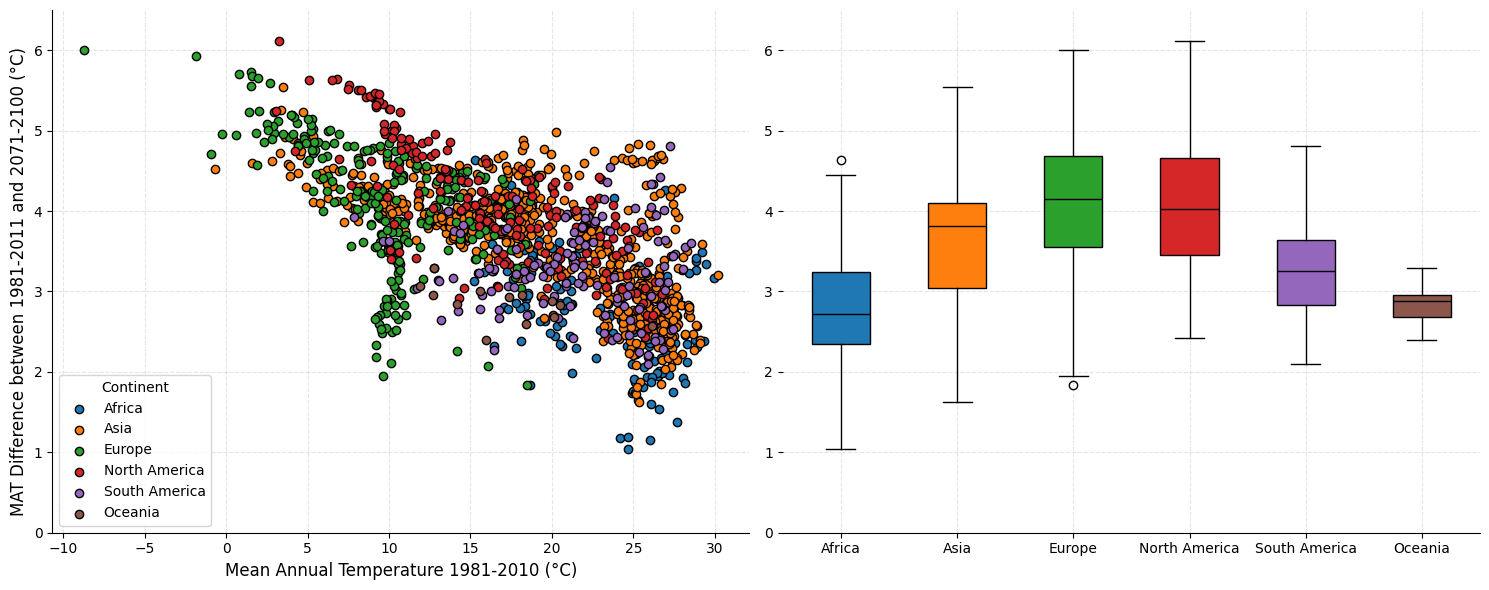

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtern, um nur die Zeilen mit Temp_Type "tas" zu verwenden
result_df_tas = result_df[result_df['Temp_Type'] == 'tas']

# Berechne die Jahresmitteltemperatur für die Zeiträume 1981-2010 und 2071-2100, indem du den Mittelwert über die Monate nimmst
mean_temps_1981_2010 = result_df_tas.groupby('City')['Temp_1981_2010'].mean().reset_index()
mean_temps_2071_2100 = result_df_tas.groupby('City')['Temp_2071_2100'].mean().reset_index()

# Benenne die Spalten um, um Verwechslungen zu vermeiden
mean_temps_1981_2010.columns = ['City', 'Mean_1981_2010']
mean_temps_2071_2100.columns = ['City', 'Mean_2071_2100']

# Führe die beiden DataFrames zusammen, um die Temperaturdifferenzen zu berechnen
mean_temps = pd.merge(mean_temps_1981_2010, mean_temps_2071_2100, on='City')

# Berechne die Differenz zwischen den Zeiträumen
mean_temps['Temp_Diff_2071_2100'] = mean_temps['Mean_2071_2100'] - mean_temps['Mean_1981_2010']

# Füge die Kontinent-Informationen aus dem ursprünglichen DataFrame hinzu
mean_temps = pd.merge(mean_temps, result_df_tas[['City', 'Continent']].drop_duplicates(), on='City')

# Farben für die Kontinente festlegen
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b'
}

# Subplots erstellen: 1 Reihe, 2 Spalten
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Remove the top and right borders
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Scatterplot (linker Plot)
for continent, color in continent_palette.items():
    continent_data = mean_temps[mean_temps['Continent'] == continent]
    axes[0].scatter(continent_data['Mean_1981_2010'], continent_data['Temp_Diff_2071_2100'],
                    alpha=1, edgecolor='black', label=continent, color=color)

# Achsenbeschriftungen und Titel für Scatterplot
#axes[0].set_title('Mean Annual Temperature vs. Temperature Difference (2071-2100)', fontsize=14)
axes[0].set_xlabel('Mean Annual Temperature 1981-2010 (°C)', fontsize=12)
axes[0].set_ylabel('MAT Difference between 1981-2011 and 2071-2100 (°C)    ', fontsize=12)
axes[0].set_ylim([0,6.5])
axes[0].grid(True, color='gray', linestyle='--', alpha=0.2)



# Legende zum Scatterplot hinzufügen
axes[0].legend(title='Continent', loc='lower left')

# Boxplots (rechter Plot)
# Erstelle Boxplots für die Temperaturdifferenzen der einzelnen Kontinente
mean_temps['Color'] = mean_temps['Continent'].map(continent_palette)  # Farbe den Kontinenten zuordnen

# Boxplot erstellen
for continent, color in continent_palette.items():
    continent_data = mean_temps[mean_temps['Continent'] == continent]
    axes[1].boxplot(continent_data['Temp_Diff_2071_2100'], 
                    positions=[list(continent_palette.keys()).index(continent)],
                    widths=0.5,
                    patch_artist=True, 
                    boxprops=dict(facecolor=color, color='black'), 
                    medianprops=dict(color='black'))

# Achsenbeschriftungen und Titel für Boxplot
#axes[1].set_title('Temperature Differences', fontsize=14)
#axes[1].set_ylabel('Temperaturdifferenz 2071-2100 (°C)', fontsize=12)
axes[1].set_xticks(range(len(continent_palette)))
axes[1].set_xticklabels(continent_palette.keys(), rotation=0)
axes[1].set_ylim([0,6.5])

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)

axes[1].grid(True, color='gray', linestyle='--', alpha=0.2)

# Layout optimieren und Plot anzeigen
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd

# Filtern auf nur 'tas'
result_df_tas = merged_with_shape[merged_with_shape['Temp_Type'] == 'tas']

# Berechne den Mittelwert der Temperaturen pro Stadt über die verschiedenen Pixel für jeden Zeitraum
mean_temps_per_city = result_df_tas.groupby('City').agg({
    'Temp_2011_2040': 'mean',
    'Temp_2041_2070': 'mean',
    'Temp_2071_2100': 'mean',
    f'{selected_ssp}_2020s': 'mean',
    f'{selected_ssp}_2070s': 'mean',
    f'{selected_ssp}_2100s': 'mean',
    'Continent': 'first'  # Kontinent bleibt gleich, daher nehmen wir den ersten Wert
}).reset_index()

# Liste aller Kontinente aus den Daten
all_continents = result_df_tas['Continent'].unique()

# Funktion zur Berechnung der Statistiken
def calculate_population_stats(df, population_column):
    stats = df.groupby('Continent').agg(
        num_cities=('City', 'count'),                    # Anzahl der Städte
        total_population=(population_column, 'sum'),     # Gesamtbevölkerung
        mean_population_per_city=(population_column, 'mean')  # Mittlere Bevölkerung pro Stadt
    ).reset_index()
    # Sicherstellen, dass alle Kontinente in den Ergebnissen sind
    stats = pd.merge(pd.DataFrame({'Continent': all_continents}), stats, on='Continent', how='left')
    stats.fillna(0, inplace=True)  # Fülle fehlende Werte (NaN) mit 0
    return stats

# Filtern der Städte mit einer mittleren Jahrestemperatur von mehr als 29°C in den jeweiligen Zeiträumen
cities_over_29_2011_2040 = mean_temps_per_city[mean_temps_per_city['Temp_2011_2040'] > 29]
cities_over_29_2041_2070 = mean_temps_per_city[mean_temps_per_city['Temp_2041_2070'] > 29]
cities_over_29_2071_2100 = mean_temps_per_city[mean_temps_per_city['Temp_2071_2100'] > 29]

# Berechnung der Statistiken für jeden Zeitraum (nur Städte über 29°C)
stats_2011_2040 = calculate_population_stats(cities_over_29_2011_2040, f'{selected_ssp}_2020s')
stats_2041_2070 = calculate_population_stats(cities_over_29_2041_2070, f'{selected_ssp}_2070s')
stats_2071_2100 = calculate_population_stats(cities_over_29_2071_2100, f'{selected_ssp}_2100s')

# Zusammenführen der Statistiken in einer Tabelle (DataFrame)
final_table_over_29 = pd.DataFrame({
    'Continent': stats_2011_2040['Continent'],
    'Num_Cities_2011_2040': stats_2011_2040['num_cities'],
    'Total_Pop_2011_2040': stats_2011_2040['total_population'],
    'Mean_Pop_per_City_2011_2040': stats_2011_2040['mean_population_per_city'],
    'Num_Cities_2041_2070': stats_2041_2070['num_cities'],
    'Total_Pop_2041_2070': stats_2041_2070['total_population'],
    'Mean_Pop_per_City_2041_2070': stats_2041_2070['mean_population_per_city'],
    'Num_Cities_2071_2100': stats_2071_2100['num_cities'],
    'Total_Pop_2071_2100': stats_2071_2100['total_population'],
    'Mean_Pop_per_City_2071_2100': stats_2071_2100['mean_population_per_city'],
})

# Speichern der finalen Tabelle in einer CSV-Datei mit dem Szenarionamen
csv_filename = f'input_tables/final_table_over_29_{selected_ssp}.csv'
final_table_over_29.to_csv(csv_filename, index=False)

# Ausgabe der finalen Tabelle
print(final_table_over_29)


       Continent  Num_Cities_2011_2040  Total_Pop_2011_2040  \
0  North America                   0.0         0.000000e+00   
1         Africa                  10.0         1.094621e+07   
2           Asia                   6.0         4.003897e+06   
3  South America                   1.0         2.041722e+06   
4        Oceania                   0.0         0.000000e+00   
5         Europe                   0.0         0.000000e+00   

   Mean_Pop_per_City_2011_2040  Num_Cities_2041_2070  Total_Pop_2041_2070  \
0                 0.000000e+00                   1.0         3.439450e+05   
1                 1.094621e+06                  13.0         2.934848e+07   
2                 6.673162e+05                  36.0         6.884456e+07   
3                 2.041722e+06                   7.0         6.435463e+06   
4                 0.000000e+00                   0.0         0.000000e+00   
5                 0.000000e+00                   0.0         0.000000e+00   

   Mean_Pop_per_Ci

In [ ]:
import pandas as pd

# Filtern auf nur 'tas'
result_df_tas = merged_with_shape[merged_with_shape['Temp_Type'] == 'tas']

# Berechne den Mittelwert der Temperaturen pro Stadt über die verschiedenen Pixel für jeden Zeitraum
mean_temps_per_city = result_df_tas.groupby('City').agg({
    'Temp_2011_2040': 'mean',
    'Temp_2041_2070': 'mean',
    'Temp_2071_2100': 'mean',
    f'{selected_ssp}_2020s': 'mean',
    f'{selected_ssp}_2070s': 'mean',
    f'{selected_ssp}_2100s': 'mean',
    'Continent': 'first'  # Kontinent bleibt gleich, daher nehmen wir den ersten Wert
}).reset_index()

# Liste aller Kontinente aus den Daten
all_continents = result_df_tas['Continent'].unique()

# Funktion zur Berechnung der Statistiken
def calculate_population_stats(df, population_column):
    stats = df.groupby('Continent').agg(
        num_cities=('City', 'count'),                    # Anzahl der Städte
        total_population=(population_column, 'sum'),     # Gesamtbevölkerung
        mean_population_per_city=(population_column, 'mean')  # Mittlere Bevölkerung pro Stadt
    ).reset_index()
    # Sicherstellen, dass alle Kontinente in den Ergebnissen sind
    stats = pd.merge(pd.DataFrame({'Continent': all_continents}), stats, on='Continent', how='left')
    stats.fillna(0, inplace=True)  # Fülle fehlende Werte (NaN) mit 0
    return stats

# Filtern der Städte mit einer mittleren Jahrestemperatur zwischen 25°C und 29°C
cities_27_to_29_2011_2040 = mean_temps_per_city[(mean_temps_per_city['Temp_2011_2040'] >= 27) & 
                                                (mean_temps_per_city['Temp_2011_2040'] <= 29)]
cities_27_to_29_2041_2070 = mean_temps_per_city[(mean_temps_per_city['Temp_2041_2070'] >= 27) & 
                                                (mean_temps_per_city['Temp_2041_2070'] <= 29)]
cities_27_to_29_2071_2100 = mean_temps_per_city[(mean_temps_per_city['Temp_2071_2100'] >= 27) & 
                                                (mean_temps_per_city['Temp_2071_2100'] <= 29)]

# Berechnung der Statistiken für Städte zwischen 25°C und 29°C
stats_27_to_29_2011_2040 = calculate_population_stats(cities_27_to_29_2011_2040, f'{selected_ssp}_2020s')
stats_27_to_29_2041_2070 = calculate_population_stats(cities_27_to_29_2041_2070, f'{selected_ssp}_2070s')
stats_27_to_29_2071_2100 = calculate_population_stats(cities_27_to_29_2071_2100, f'{selected_ssp}_2100s')


# Zusammenführen der Statistiken in einer Tabelle (DataFrame) für Städte zwischen 25°C und 29°C
final_table_27_to_29 = pd.DataFrame({
    'Continent': stats_27_to_29_2011_2040['Continent'],
    'Num_Cities_2011_2040': stats_27_to_29_2011_2040['num_cities'],
    'Total_Pop_2011_2040': stats_27_to_29_2011_2040['total_population'],
    'Mean_Pop_per_City_2011_2040': stats_27_to_29_2011_2040['mean_population_per_city'],
    'Num_Cities_2041_2070': stats_27_to_29_2041_2070['num_cities'],
    'Total_Pop_2041_2070': stats_27_to_29_2041_2070['total_population'],
    'Mean_Pop_per_City_2041_2070': stats_27_to_29_2041_2070['mean_population_per_city'],
    'Num_Cities_2071_2100': stats_27_to_29_2071_2100['num_cities'],
    'Total_Pop_2071_2100': stats_27_to_29_2071_2100['total_population'],
    'Mean_Pop_per_City_2071_2100': stats_27_to_29_2071_2100['mean_population_per_city'],
})

# Speichern der finalen Tabellen in CSV-Dateien mit dem Szenarionamen
csv_filename_27_to_29 = f'input_tables/final_table_27_to_29_{selected_ssp}.csv'
final_table_27_to_29.to_csv(csv_filename_27_to_29, index=False)

# Ausgabe der finalen Tabellen

print("\nStädte zwischen 27°C und 29°C:")
print(final_table_27_to_29)



Städte zwischen 27°C und 29°C:
       Continent  Num_Cities_2011_2040  Total_Pop_2011_2040  \
0  North America                   1.0         9.063157e+05   
1         Africa                  20.0         1.238172e+07   
2           Asia                 119.0         1.868670e+08   
3  South America                  17.0         1.496299e+07   
4        Oceania                   0.0         0.000000e+00   
5         Europe                   0.0         0.000000e+00   

   Mean_Pop_per_City_2011_2040  Num_Cities_2041_2070  Total_Pop_2041_2070  \
0                 9.063157e+05                   8.0         5.995152e+06   
1                 6.190859e+05                  51.0         1.837801e+08   
2                 1.570311e+06                 141.0         3.920772e+08   
3                 8.801759e+05                  20.0         2.017499e+07   
4                 0.000000e+00                   1.0         6.389539e+05   
5                 0.000000e+00                   0.0         0.0

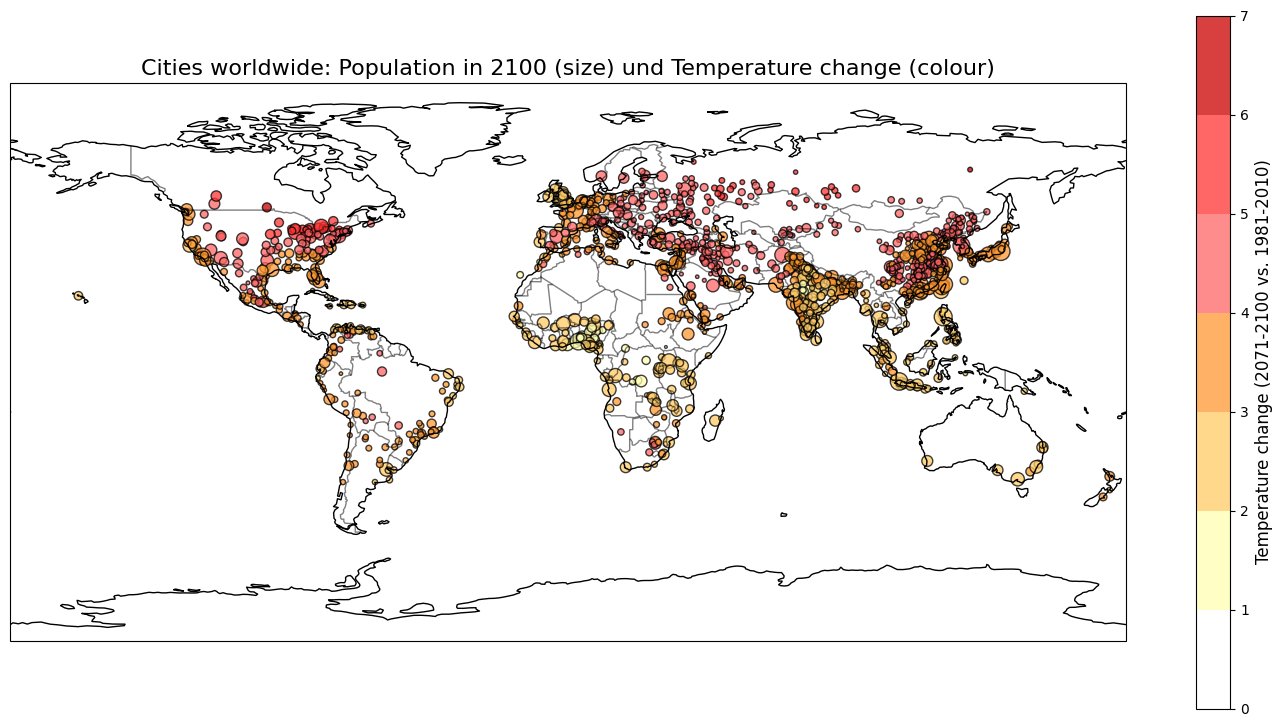

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature  # Das richtige Modul für geografische Features
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Filtern auf nur 'tas'
result_df_tas = merged_with_shape[merged_with_shape['Temp_Type'] == 'tas']

# Berechne den Mittelwert der Temperaturen pro Stadt über die verschiedenen Pixel für jeden Zeitraum
mean_temps_per_city = result_df_tas.groupby('City').agg({
    'x-Koord': 'median',
    'y-Koord': 'median',
    'Temp_1981_2010': 'mean',
    'Temp_2071_2100': 'mean',
    f'{selected_ssp}_2100s': 'mean',
}).reset_index()

# Berechne die Temperaturänderung zwischen 1981-2010 und 2071-2100
mean_temps_per_city['Temp_Change'] = mean_temps_per_city['Temp_2071_2100'] - mean_temps_per_city['Temp_1981_2010']

# Erstelle eine diskrete Farbskala von Weiß bis Rot (0°C bis 7°C)
cmap = ListedColormap(['#ffffff', '#ffffb2', '#ffcc66', '#ff9933', '#ff6666', '#ff3333', '#cc0000'])
bounds = [0, 1, 2, 3, 4, 5, 6, 7]
norm = BoundaryNorm(bounds, cmap.N)

# Erstelle eine Weltkarte mit Cartopy
fig = plt.figure(figsize=(18, 9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Zeichne die Küstenlinien und Ländergrenzen
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)  # Korrekte Verwendung für Ländergrenzen

# Skalierung der Punktgröße basierend auf der Bevölkerung im Jahr 2100
population_size = np.sqrt(mean_temps_per_city[f'{selected_ssp}_2100s']) / 30  # Bevölkerung für 2100 skalieren

# Zeichne die Städte als Punkte auf die Karte
scatter = plt.scatter(mean_temps_per_city['x-Koord'], mean_temps_per_city['y-Koord'], 
                      s=population_size,  # Durchmesser basierend auf Bevölkerung
                      c=mean_temps_per_city['Temp_Change'],  # Farbe basierend auf der Temperaturänderung
                      cmap=cmap, norm=norm,  # Diskrete Farbskala Weiß bis Rot
                      alpha=0.75, edgecolor='k', transform=ccrs.PlateCarree())

# Farblegende für die Temperaturänderung hinzufügen
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05, ticks=bounds)
cbar.set_label('Temperature change (2071-2100 vs. 1981-2010)', fontsize=12)

# Titel der Karte
plt.title('Cities worldwide: Population in 2100 (size) und Temperature change (colour)', fontsize=16)

# Karte anzeigen
plt.show()


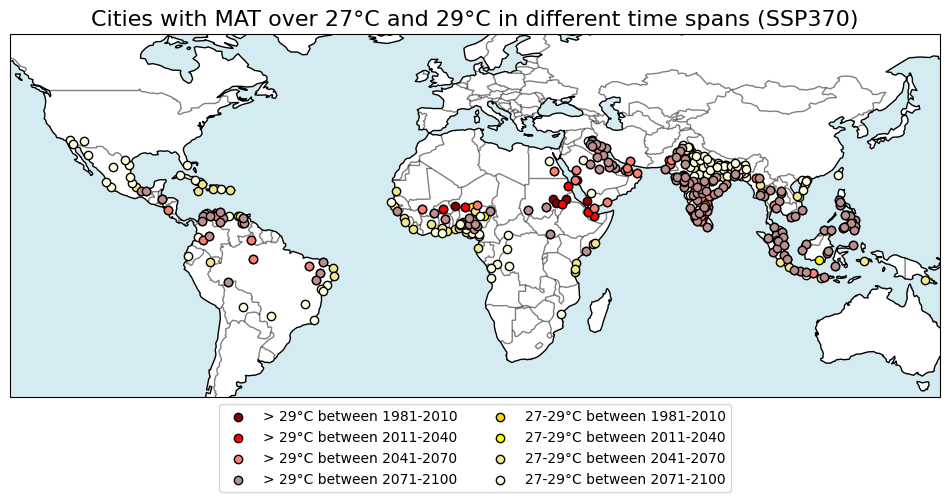

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

# Filter on only 'tas'
result_df_tas = merged_with_shape[merged_with_shape['Temp_Type'] == 'tas']

# Calculate the mean temperature per city over the various pixels for each period
mean_temps_per_city = result_df_tas.groupby('City').agg({
    'x-Koord': 'median',
    'y-Koord': 'median',
    'Temp_1981_2010': 'mean',
    'Temp_2011_2040': 'mean',
    'Temp_2041_2070': 'mean',
    'Temp_2071_2100': 'mean',
}).reset_index()

# Determine a bounding box for the cities with a smaller margin (e.g., 2°)
margin = 2  # Reduced margin for closer zoom
min_lon = mean_temps_per_city['x-Koord'].min() - margin
max_lon = mean_temps_per_city['x-Koord'].max() + margin
min_lat = mean_temps_per_city['y-Koord'].min() - margin
max_lat = mean_temps_per_city['y-Koord'].max() + margin

# Define city groups based on temperature thresholds
cities_over_29_1981_2010 = mean_temps_per_city[mean_temps_per_city['Temp_1981_2010'] > 29]
cities_over_29_2011_2040 = mean_temps_per_city[(mean_temps_per_city['Temp_2011_2040'] > 29) & (mean_temps_per_city['Temp_1981_2010'] <= 29)]
cities_over_29_2041_2070 = mean_temps_per_city[(mean_temps_per_city['Temp_2041_2070'] > 29) & (mean_temps_per_city['Temp_2011_2040'] <= 29)]
cities_over_29_2071_2100 = mean_temps_per_city[(mean_temps_per_city['Temp_2071_2100'] > 29) & (mean_temps_per_city['Temp_2041_2070'] <= 29)]

cities_27_29_1981_2010 = mean_temps_per_city[(mean_temps_per_city['Temp_1981_2010'] >= 27) & (mean_temps_per_city['Temp_1981_2010'] <= 29)]
cities_27_29_2011_2040 = mean_temps_per_city[(mean_temps_per_city['Temp_2011_2040'] >= 27) & (mean_temps_per_city['Temp_2011_2040'] <= 29) & (mean_temps_per_city['Temp_1981_2010'] < 27)]
cities_27_29_2041_2070 = mean_temps_per_city[(mean_temps_per_city['Temp_2041_2070'] >= 27) & (mean_temps_per_city['Temp_2041_2070'] <= 29) & (mean_temps_per_city['Temp_2011_2040'] < 27)]
cities_27_29_2071_2100 = mean_temps_per_city[(mean_temps_per_city['Temp_2071_2100'] >= 27) & (mean_temps_per_city['Temp_2071_2100'] <= 29) & (mean_temps_per_city['Temp_2041_2070'] < 27)]

# Create a map with Cartopy
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set extent to focus on the cities (plus the reduced margin)
ax.set_extent([min_lon+25, max_lon-25, min_lat, max_lat], crs=ccrs.PlateCarree())

# Draw coastlines and borders
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)

# Plot cities > 29°C in various red tones
ax.scatter(cities_over_29_1981_2010['x-Koord'], cities_over_29_1981_2010['y-Koord'],
           color='darkred', edgecolor='black',
           label='> 29°C between 1981-2010', transform=ccrs.PlateCarree(), zorder=5)
ax.scatter(cities_over_29_2011_2040['x-Koord'], cities_over_29_2011_2040['y-Koord'],
           color='red', edgecolor='black',
           label='> 29°C between 2011-2040', transform=ccrs.PlateCarree(), zorder=5)
ax.scatter(cities_over_29_2041_2070['x-Koord'], cities_over_29_2041_2070['y-Koord'],
           color='salmon', edgecolor='black',
           label='> 29°C between 2041-2070', transform=ccrs.PlateCarree(), zorder=5)
ax.scatter(cities_over_29_2071_2100['x-Koord'], cities_over_29_2071_2100['y-Koord'],
           color='rosybrown', edgecolor='black',
           label='> 29°C between 2071-2100', transform=ccrs.PlateCarree(), zorder=5)

# Plot cities between 27°C and 29°C in different yellow/green tones
ax.scatter(cities_27_29_1981_2010['x-Koord'], cities_27_29_1981_2010['y-Koord'],
           color='gold', edgecolor='black',
           label='27-29°C between 1981-2010', transform=ccrs.PlateCarree(), zorder=4)
ax.scatter(cities_27_29_2011_2040['x-Koord'], cities_27_29_2011_2040['y-Koord'],
           color='yellow', edgecolor='black',
           label='27-29°C between 2011-2040', transform=ccrs.PlateCarree(), zorder=4)
ax.scatter(cities_27_29_2041_2070['x-Koord'], cities_27_29_2041_2070['y-Koord'],
           color='khaki', edgecolor='black',
           label='27-29°C between 2041-2070', transform=ccrs.PlateCarree(), zorder=4)
ax.scatter(cities_27_29_2071_2100['x-Koord'], cities_27_29_2071_2100['y-Koord'],
           color='lightyellow', edgecolor='black',
           label='27-29°C between 2071-2100', transform=ccrs.PlateCarree(), zorder=4)

# Place the legend below the map in a 4x2 matrix (4 columns, 2 rows)
plt.legend(bbox_to_anchor=(0.5, 0), loc='upper center', ncol=2, fontsize=10)

# Add a title
plt.title('Cities with MAT over 27°C and 29°C in different time spans (SSP370)', fontsize=16)

plt.show()
